
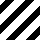
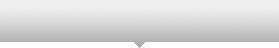
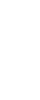
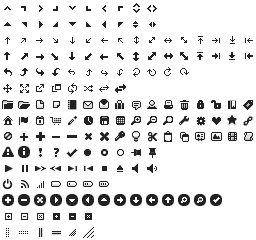
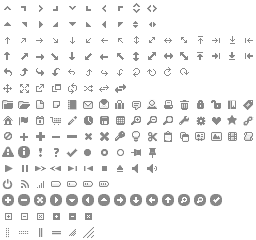
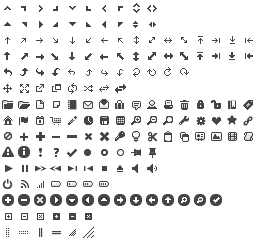
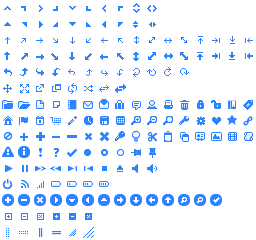
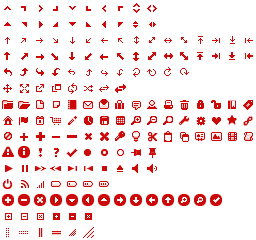
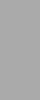
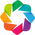
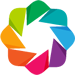
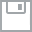
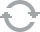
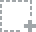
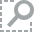
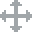
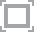
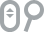

In [1]:
import pandas as pd
import numpy as np

from bokeh.plotting import figure, gridplot
from bokeh.io import show, output_notebook
from bokeh.models import Callback, ColumnDataSource, HoverTool

output_notebook()

In [10]:
from keputils import koiutils as ku
from keputils import kicutils as kicu
import numpy as np
import pandas as pd

from keputils import koiutils as ku
from keputils import kicutils as kicu

starprops = pd.read_table('starprops_all.txt', delim_whitespace=True)
starprops['koistar'] = starprops['koi'].apply(ku.koistar)

sp = starprops.groupby('koistar').first()

huber_sp = kicu.DATA.ix[ku.DATA.ix[sp['koi'], 'kepid']]

In [16]:
def make_sources(data=sp, prop='teff', query='teff > 0'):
    
    huber_df = huber_sp.query(query.lower())
    
    huber_values = np.sort(huber_df[prop.lower()])
    sorted_inds = np.argsort(huber_df[prop.lower()])
    
    huber_values_lo = np.array(huber_df[prop.lower()] + huber_df['{}_err2'.format(prop.lower())])[sorted_inds]
    huber_values_hi = np.array(huber_df[prop.lower()] + huber_df['{}_err1'.format(prop.lower())])[sorted_inds]
    y_lo = huber_values_lo
    y_hi = huber_values_hi
    
    kics = huber_df.index[sorted_inds]

        
    df = data.copy()
    df.index = ku.DATA.ix[df['koi'], 'kepid']

    val = df.ix[kics, prop]
    val_lo = df.ix[kics, '{}_lo'.format(prop)]
    val_hi = df.ix[kics, '{}_hi'.format(prop)]

    inds = np.arange(len(huber_values))
    
    x = inds
    y = val
    my_lo = val_lo
    my_hi = val_hi
    
    source = ColumnDataSource(
        data = dict(
            id_to_index = huber_df.index, #ids
            index_to_id = sorted_inds, #order of ids 
            x = x,
            y = y,
            x0 = x - 0.5,
            x1 = x + 0.5,
            my_center = (my_hi + my_lo)/2,
            my_height = my_hi - my_lo,
        )
    )
    
    err_x = np.concatenate([x, x[::-1]])
    err_y = np.concatenate([y_hi, y_lo[::-1]])
    
    err_source = ColumnDataSource(
        data = dict(
            x = err_x, 
            y = err_y,
        )
    )
    
    out_mask = (my_lo > y_hi) | (my_hi < y_lo)
    out_hi = my_hi[out_mask]
    out_lo = my_lo[out_mask]

    out_source = ColumnDataSource(
        data = dict(
            x = x[out_mask],
            y = (out_hi + out_lo)/2,
            height = out_hi - out_lo,
        )
    )

    
    return source, err_source, out_source

In [3]:
def make_plot(source, err_source, out_source):
    p = figure(plot_width=1000, plot_height=300)

    p.lod_factor = 5
    p.xaxis.major_label_text_color = None
    p.xaxis.major_tick_line_color = None
    p.xaxis.minor_tick_line_color = None
    p.xgrid.grid_line_color = None

    # draw the filled error area
    p.patch(x="x", y="y", alpha=0.1, color="navy", source=err_source)

    # draw the dashes and bars for my observations
    p.segment(x0="x0", x1="x1", y0="y", y1="y", alpha=0.6, color="navy", source=source, name="nohit")
    p.rect(x="x", y="my_center", width=3, width_units="screen", height="my_height", 
           color="black", line_color=None, alpha=0.05, source=source, name="hit")
    
    r = p.select(name="hit")[0]
    r.nonselection_glyph = r.glyph.clone()
    r.selection_glyph = r.glyph.clone()
    r.selection_glyph.fill_alpha = 1
    r.selection_glyph.fill_color = "navy"

    r = p.select(name="nohit")[0]
    r.nonselection_glyph = r.glyph.clone()
    r.selection_glyph = r.glyph.clone()
    
    # draw the outliers
    p.rect(x="x", y="y", width=0.5, height="height", color="firebrick", alpha=0.3, source=out_source)
    
    return p

In [17]:
p0 = make_plot(*make_sources(prop='Teff'))
p1 = make_plot(*make_sources(prop='feh'))

code = """
    var sources = [other0]
    var idx = cb_data['index']['1d'].indices;
    var index_to_id = s.get('data')['index_to_id']
    for (i = 0; i < sources.length; i++) {
        var selected = {'0d': {flag: false, indices: []}, '1d': {indices: []}, '2d': {indices: []}};
        var id_to_index = sources[i].get('data')['id_to_index']
        for (j = 0; j < idx.length; j++) {
            id = index_to_id[idx[j]]
            index = id_to_index[id]
            selected['1d'].indices.push(index);
        }
        sources[i].set('selected', selected);
    }
    s.set('selected', cb_data['index'])
"""

s0 = p0.select(name="hit")[0].data_source
s1 = p1.select(name="hit")[0].data_source

p0.add_tools(HoverTool(callback=Callback(args=dict(s=s0, other0=s1), code=code), 
                       tooltips=None, renderers=p0.select(name='hit')))

p0.add_tools(HoverTool(renderers=p0.select(name='hit'), tooltips=[('id', '@index_to_id')]))

p1.add_tools(HoverTool(callback=Callback(args=dict(s=s1, other0=s0), code=code), 
                       tooltips=None, renderers=p1.select(name='hit')))

/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:59: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [18]:
show(gridplot([[p0], [p1]]))

ERROR:/Users/tdm/repositories/bokeh/bokeh/validation/check.pyc:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 6855abaf-edf2-46d5-8186-caf50095ac20
ERROR:/Users/tdm/repositories/bokeh/bokeh/validation/check.pyc:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: dd81a708-c596-4eaa-9a90-a426d218757d
